# Probabilistic Iterative Learning Modal

- Given a initial completely precise (non-vague) language as input, do vague meaning representations arise as a result of the semantic bottleneck and reasoning of agents regarding how to extend the meanings of the expressions they have learned?

In [10]:
import pandas as pd
import numpy as np
import random
from scipy.stats import rv_discrete
from scipy import stats
from random import choices
import matplotlib.pyplot as plt
%matplotlib inline

## Parameters for the model

- ```num_sits```: the number of situation types that the agents can be exposed to in their learning data/may have to describe to a leanring of the next generation. Situations are assumed to form an order [num_sits must be equal to num_preds]
- ```num_preds```: the number of situation predicates that agent 0 has in her precise language. [num_sits must be equal to num_preds]
- ```num_sits_preds```: since num_sits must be equal to num_preds, only one value is input
- ```data_size```: the number of situation-predicate pairs each generation receives as learning data. 
- ```delta```: if a generation does not directly experience a descrption of a situation, they must infer which of the predicetes they have experienced to use to describe this situation. The delta parameter controls how distance between situations in the order affects this reasoning such that delta is a numeral that multiples the distance measure between situations
- ```num_gen```: the number of generations the iterated learning model will cycle through.
- ```noise_var```: noise is modelled by applying a gaussian distribution to the learning data such that if the noise free message is [sit, pred], the learner has uncertainty about which sit is being described with sit as the mean and ```noise_var``` as the  standard deviation.
- ```pathname```: the csv file name under which the results for the final generation will be saved.

In [11]:
#noise_var should be above 0. A value of 0.01 counts as no noise for practical purposes. 
num_gen = 30
num_sits_preds = 15
data_size = 60
noise_var = 0.01
delta = 0.5
pathname="my_csv_filename.csv"

num_sits = num_sits_preds
num_preds = num_sits_preds

When running the model, tables are generated for the 50th, 40th, 30th, 20th, and 10th from last generations as well as for the last generation. 

The results for the final generation are saved as a csv. This is also represented graphically.

## Agent 0: the first generation

This agent has a language l0 that is completely precise. For each situation, there is one unique predicte Agent 0 will use to describe this situation and for each predicte, there is one unique situation (type) that this predicate describes.

In [12]:
sits = list(range(0,num_sits))
preds = list(range(0,num_preds))
zero_data = np.zeros(shape=(len(sits),len(preds)))
l0_prob_pred_given_sit = pd.DataFrame(zero_data, columns=preds)
#Generate Lang 1: a df with 1 pred per sit where p(pred|sit) = 1
for x, y in zip(sits, preds):
    l0_prob_pred_given_sit.iloc[x,y] = 1

#l0_prob_pred_given_sit.iloc[0,2] = 2    
l0_prior_pred = []
for pred in preds:
    l0_prior_pred.append((pred, 1/num_preds)) 
    
l0_prior_sit = []
for sit in sits:
    l0_prior_sit.append((sit, 1/num_sits)) 

## The probabilistic iterative learning function with noise

In [13]:
def it_learning_bn2(prev_ag):
    #sits_described lists the situations the speaker must describe to the learner. 
    #This is controlled by the data_size parameter. 
    sits_described = choices(range(0, len(sits)), k=data_size)
    
    #The speakers distributions P(Pred|Sit) are used to generate a set of (sit, pred) pairs. This represents 
    #completely noise-free learning data. Noise is added subsequently.
    learning_data_no_noise = []
    for sit in sits_described:
        learning_data_no_noise.append((sit,int(np.random.choice(np.arange(0, len(sits)), size=1, p=prev_ag.iloc[sit]))))
    #learning_data_no_noise is a list of tuples (sit, pred)    
    #Noise is added. The learner is certin what predicate is being used but some uncertainty is introduced 
    learning_data_with_noise = []
    for data in learning_data_no_noise:
        norm_value_list = []
        for sit in sits:
            norm_value_list.append(stats.norm(data[0], noise_var).pdf(sit))
            norm_value = sum(norm_value_list)
        learning_data_point_with_noise = []
        for sit in sits:    
            learning_data_point_with_noise.append(stats.norm(data[0], noise_var).pdf(sit) / norm_value)
        learning_data_with_noise.append(learning_data_point_with_noise) 
        
    #final_learning_data_with_noise=[]    
    for data, dist in zip(learning_data_no_noise,learning_data_with_noise):
        dist.append(data[0])
        dist.append(data[1])
    #The learners distributions p(sit|pred) based on each data point. Not yet combined. 
    #Final columns are sit, pred of learning_data_no_noise.
    learn_data_noise_df = pd.DataFrame(learning_data_with_noise)
    
    #To calculate p(pred|sit), we first calculate the priors p(sit), p(pred) 
    #p(pred), output as a list of tuples, (pred, prior). 
    zero_pred_counts = np.zeros(shape=(len(preds), 1))
    pred_counts = pd.DataFrame(zero_pred_counts)
    for data in learning_data_no_noise:
        pred_counts.iloc[data[1]] += 1
    prior_prob_pred_list_df = pred_counts/data_size
    
    #prior_prob_pred_list_df is a series, the indices are preds, the values are priors
    #Calculation of the priors for each sit
    learn_data_noise_only_cond_probs = learn_data_noise_df.iloc[:, :-2]
    prior_prob_sit_list = []
    for sit in sits: 
        prior_prob_sit_list.append(learn_data_noise_only_cond_probs.sum()[sit]/learn_data_noise_only_cond_probs.sum().sum())
    
    prior_prob_sit_list_df = pd.DataFrame(prior_prob_sit_list)    
    #prior_prob_sit_list_df is a series, the indices are sits, the values are priors
    #Generate a new df of zeros that will be filled in with P(sit|pred)
    zero_data_new = pd.DataFrame(np.zeros(shape=(len(sits),len(preds))))
    #This loop selects for P(sit \ pred) for each pred, and then averages over the values
    for pred in preds:
        learn_data_noise_df_pred = learn_data_noise_df[learn_data_noise_df.iloc[:, -1] == pred]
        number_pred_instances = learn_data_noise_df_pred.shape[0]
        learn_data_noise_df_pred_only_data = learn_data_noise_df_pred.iloc[ : , :-2]
        learn_data_noise_df_pred_only_data_sums = pd.DataFrame(learn_data_noise_df_pred_only_data.sum(axis=0))
        if number_pred_instances>0:
            zero_data_new.iloc[:,pred] = learn_data_noise_df_pred_only_data_sums /  learn_data_noise_df_pred.shape[0]
        else: zero_data_new.iloc[:,pred] = learn_data_noise_df_pred_only_data_sums
    
    prob_sit_given_pred_learner = zero_data_new.copy()
    
    #Generate a new df of zeros that will be filled in with P(pred|sit)
    prob_pred_give_sit_learner = pd.DataFrame(np.zeros(shape=(len(sits),len(preds))))
    
    #This loop calculates P(pred|sit)
    for pred in preds:
        for sit in sits:
            prob_pred_give_sit_learner.iloc[sit, pred] = (prob_sit_given_pred_learner.iloc[sit, pred] * prior_prob_pred_list_df.iloc[pred]) / prior_prob_sit_list_df.iloc[sit]  
    
    #For cases where sits are not witnessed and where, even with noise, the prior for a sit is 0,
    #we can calculate how a rational agent should apply a pred on the basis of how similar the
    #unwitnessed situation is to witnessed ones. 
    prob_pred_give_sit_learner = prob_pred_give_sit_learner.copy().fillna(value=0)

    #Calculate a distance measure. This measures the distance a [sit, pred] cell in P(pred|sit) is away from a witnessed value.
    l1 = prob_pred_give_sit_learner.copy()
    
    dist_l1 = l1.copy()
    dicta_l1 = {}
    dictb_l1 = {}
    for ind0 in list(range(0,num_preds)):
        dicta_l1[ind0] = dist_l1.iloc[:, ind0] > 0
        if not  [i for i, y in enumerate(dicta_l1[ind0]) if y] == False:
            dictb_l1[ind0] = [i for i, y in enumerate(dicta_l1[ind0]) if y]
            if dictb_l1[ind0] == []:
                dictb_l1[ind0] = [9999999]
    for col in list(range(0,num_preds)):
        for row in list(range(0,num_sits)):
            if (row < max(dictb_l1[col])) and (row > min(dictb_l1[col])):
                dist_l1.iloc[row, col] = 0
            elif row == max(dictb_l1[col]):
                dist_l1.iloc[row, col] = 0
            elif row == min(dictb_l1[col]):
                dist_l1.iloc[row, col] = 0
            elif (max(dictb_l1[col]) < 9999999) and (row > max(dictb_l1[col])):
                dist_l1.iloc[row, col] = abs(row - max(dictb_l1[col]))
            elif (max(dictb_l1[col]) < 9999999) and (row < min(dictb_l1[col])):
                dist_l1.iloc[row, col] = abs(row - min(dictb_l1[col]))
    
    l1_down = l1.copy()
    l1_up = l1.copy()
    l1_down['sum_rows'] = l1.apply(sum,axis=1)
    l1_up['sum_rows'] = l1.apply(sum,axis=1)
    
    #Populate the learner's data with 1's to fill missing gaps
    for row in list(range(0,num_sits)):
        if l1_down['sum_rows'].iloc[row] == 0 and row != 0:
            l1_down.iloc[row] = l1_down.copy().iloc[row - 1]
    for row in list(reversed(range(0,num_sits))):
        if l1_up['sum_rows'].iloc[row] == 0 and row != (num_sits - 1):
            l1_up.iloc[row] = l1_up.copy().iloc[row + 1]
    l1_up = l1_up.copy().drop('sum_rows', axis=1)
    l1_down = l1_down.copy().drop('sum_rows', axis=1)
    l1_up_down = l1_up + l1_down
    for row in list(range(0,num_sits)):
        for col in list(range(0,num_preds)):
            if l1_up_down.iloc[row, col] > 1:
                l1_up_down.iloc[row, col] = 1
    l1 = l1_up_down.copy()
    #Calculate the probability P(P|S), given the learning data and the distance measure. 
    #This extrapolates how a learner should apply a pred to an un-witnessed situation based on witnessed predicate usage.
    l1_prop_a = l1.apply(np.log, axis = 0)
    l1_prop_b = delta * dist_l1
    l1_prop_c = l1_prop_a - l1_prop_b
    l1_prop = np.exp(l1_prop_c)
    l1_normed = l1_prop.copy()
    for row in list(range(0,num_sits)):
        sum_row = l1_prop.iloc[row].sum()
        l1_normed.iloc[row] = l1_prop.iloc[row].divide(sum_row)
    l1_normed = l1_normed.copy().fillna(0)
    next_ag = l1_normed.copy()
    #print(learning_data_no_noise)
    #print(next_ag)
    return next_ag


## Running the model

- The function ```f``` runs the function ```it_learning_bn1``` ```n``` times, feeding the output of ```it_learning_bn1``` on the previous generation as an input to the next generation
- The output prints a dataframe for the final 50 generations, every 10 generations. 



In [14]:
def f(lang, n=num_gen):
    while n > 0:
        yield lang     
        lang = it_learning_bn2(lang)    
        n -= 1
        if n in [50,40,30,20,10,0]:
            gen = num_gen - n
            print('P(Pred|Sit) for generation '+str(gen))
            print(lang)
            print('\n')
            

          

In [15]:
for value in f(l0_prob_pred_given_sit, num_gen):  
    last_ag = value  


P(Pred|Sit) for generation 10
      0    1    2    3    4    5    6    7    8    9   10   11   12   13   14
0   1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
1   0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
2   0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
3   0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
4   0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
5   0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
6   0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
7   0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0
8   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0
9   0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0
10  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0
11  0.0  0.0  0.0  0.0  0.0  0.0  

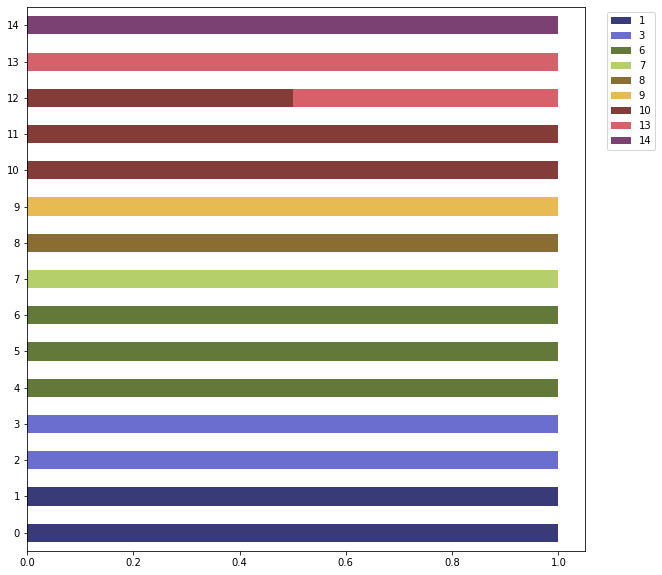

In [16]:
cols_to_drop = []

for col in preds:
    if last_ag.iloc[:, col].sum() == 0:
        cols_to_drop.append(col)
        
cols_to_drop
        
last_ag_red = last_ag.copy()
last_ag_red = last_ag_red.copy().drop(last_ag_red.columns[cols_to_drop], axis=1)


colors = plt.cm.tab20b(np.linspace(start=0, stop=40, num=400)) 
#colors = plt.cm.hsv(np.linspace(start=0, stop=50, num=1000))  
ax = last_ag_red.plot.barh(stacked=True, figsize=(10,10), color=colors)
horiz_offset = 1.03
vert_offset = 1.
ax.legend(bbox_to_anchor=(horiz_offset, vert_offset))
plt.show()

In [17]:
last_ag_red.to_csv(pathname)